In [ ]:
import kagglehub
import cv2
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Dataset path:", path)

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Dataset path: /kaggle/input/new-plant-diseases-dataset


In [ ]:
def apply_advanced_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    return final

In [ ]:
def apply_dwt(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coeffs = pywt.dwt2(img_gray, 'haar')
    cA, (cH, cV, cD) = coeffs

    # Normalize and stack as 3-channel
    combined = np.stack((cA, cH, cV), axis=-1)
    combined = cv2.resize(combined, (image.shape[1], image.shape[0]))
    combined = cv2.normalize(combined, None, 0, 255, cv2.NORM_MINMAX)
    return combined.astype(np.uint8)

In [ ]:
def gamma_correction(image, gamma=1.5):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

In [ ]:
def preprocess(image):
    image = cv2.resize(image, (224, 224))

    clahe_img = apply_advanced_clahe(image)
    dwt_img = apply_dwt(clahe_img)
    gamma_img = gamma_correction(dwt_img, gamma=1.7)

    return gamma_img

In [ ]:
data_augment = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    preprocessing_function=preprocess
)

In [ ]:
import os

# auto-detect train folder
def find_train_folder(base):
    for root, dirs, files in os.walk(base):
        if "train" in dirs:
            return os.path.join(root, "train")
    return None

train_dir = find_train_folder(path)

print("Detected train folder:", train_dir)


Detected train folder: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train


In [ ]:
train_gen = data_augment.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.


In [ ]:
import os

print("Dataset path:", path)

for root, dirs, files in os.walk(path):
    print(root)
    break


Dataset path: /kaggle/input/new-plant-diseases-dataset
/kaggle/input/new-plant-diseases-dataset


In [ ]:
for root, dirs, files in os.walk(path, topdown=True):
    if "train" in root:
        print(root)
        break


/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train


In [ ]:
sample_class = None
train_path = None

for root, dirs, files in os.walk(path):
    if root.endswith("train"):
        train_path = root
        sample_class = os.listdir(train_path)[0]
        break

print("Train folder:", train_path)
print("Class folder:", sample_class)
print("Images inside:", os.listdir(f"{train_path}/{sample_class}")[:5])


Train folder: /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Class folder: Tomato___Late_blight
Images inside: ['781e93a9-2059-42de-8075-658033a6abf7___RS_Late.B 6075.JPG', '1e0c01b6-5d75-47ea-b455-c9508882424a___RS_Late.B 6886_flipLR.JPG', '283ff0be-6e5e-4b4e-bf21-639780b77ffc___GHLB2 Leaf 8636.JPG', '0db85707-41f9-42df-ba3b-842d14f00a68___GHLB2 Leaf 8909.JPG', '3ae2b5f3-a42f-49b1-8d27-dcfaaeda602f___GHLB2 Leaf 8840_flipLR.JPG']


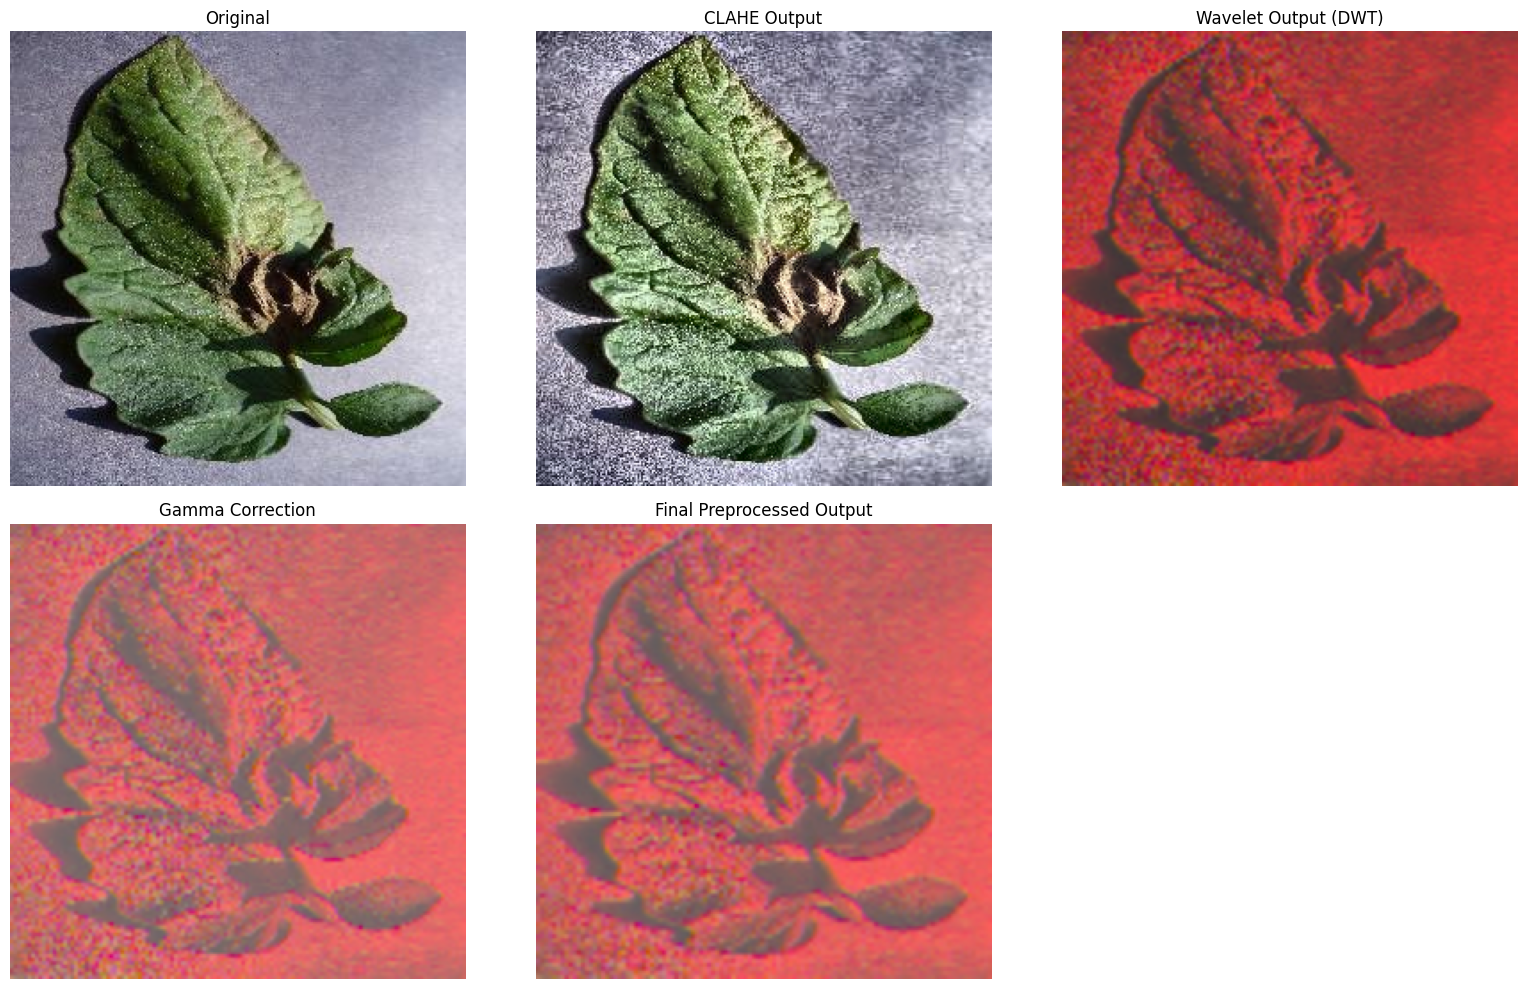

In [ ]:
sample_image = f"{train_path}/{sample_class}/{os.listdir(train_path+'/'+sample_class)[0]}"
show_all_outputs(sample_image)